In [1]:
from transformers import AutoImageProcessor, AutoModel
import torch
import torch.functional as F
from torch.utils.data import DataLoader
from src.model import SiameseDino
from src.train import evaluate
from src.data import CachedCollection, LazyLoadCollection, extract_paths_and_labels, make_transform
from pathlib import Path
import chromadb
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

/home/timothee/anaconda3/envs/DIHT/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/home/timothee/anaconda3/envs/DIHT/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened bec

In [2]:
base_model_name = "facebook/dinov3-vitb16-pretrain-lvd1689m"
processor = AutoImageProcessor.from_pretrained(base_model_name)
dinov3_model = AutoModel.from_pretrained(
    base_model_name,
    dtype=torch.float32
)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

In [29]:
hidden_dim = 512
output_dim = 128
device = torch.device("cuda" if torch.backends.mps.is_available() else "cpu")
siamese_model = SiameseDino(dinov3_model, hidden_dim, output_dim)
siamese_model.load_state_dict(torch.load("../model_checkpoints/best_train_color_invariant_LLft.pth"))
_ = siamese_model.to(device)

In [4]:
original_root_path = Path("../data/original_data")
gallery_paths, gallery_labels = extract_paths_and_labels(original_root_path)
gallery = CachedCollection(gallery_paths, gallery_labels, make_transform())
gallery_dataloader = DataLoader(gallery, batch_size=32)

In [30]:
@torch.no_grad()
def compute_all_embeddings(gallery_dataloader, processor, model) -> np.ndarray:
    all_embeddings = []
    all_paths = []
    for i, (images, _) in enumerate(gallery_dataloader):
        inputs = processor(images=images, return_tensors="pt").to(model.device)
        emb = model(**inputs)
        if not model.normalize:
            emb = F.normalize(emb, p=2, dim=1)  # normalize
        all_embeddings.append(emb.cpu())
        all_paths.extend(gallery_dataloader.dataset.paths[i*gallery_dataloader.batch_size:(i+1)*gallery_dataloader.batch_size])
    
    return torch.cat(all_embeddings, dim=0), all_paths

embeddings, paths = compute_all_embeddings(gallery_dataloader, processor, siamese_model)

In [31]:
client = chromadb.Client()
if "Capsules" in [c.name for c in client.list_collections()]:
    client.delete_collection("Capsules") 
collection = client.create_collection(name="Capsules")

In [32]:
collection.add(paths, embeddings.numpy())

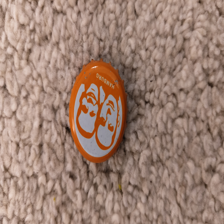

In [ ]:
@torch.no_grad()
def get_closest(image: Image, collection: chromadb.Collection, processor: AutoImageProcessor, model: SiameseDino):
    input = processor(images=image, return_tensors="pt").to(model.device)
    embedding = model(**input).cpu().numpy()
    res = collection.query(embedding)

    return res["ids"]

def show_closest(k: int, query: Image, collection: chromadb.Collection, processor: AutoImageProcessor, model: SiameseDino):
    
    # List of PIL images
    imgs = [Image.open(get_closest(query, collection, processor, model)[0][i]).resize((224, 224)) for i in range(k)]

    # Determine grid size
    cols = k
    rows = int(np.ceil(len(imgs) / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(8, 8))
    axes = axes.flatten()

    for i, img in enumerate(imgs):
        axes[i].imshow(img)
        axes[i].axis('off')

    # Hide unused axes if there are fewer images than slots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

test_data_path = Path("../data/test_dataset")
queries_paths = [path for path in test_data_path.iterdir()]
query = Image.open(queries_paths[9]).resize((224, 224))
query

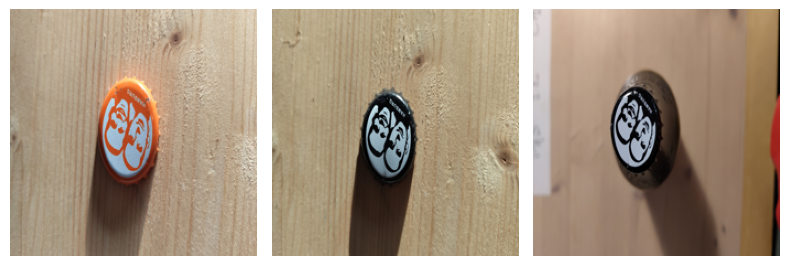

In [61]:
k=3
show_closest(k, query, collection, processor, siamese_model)